# Data Sourcing 

* Get EOPatches From Different Locations using GeoJsons
* Split Each EOPatch into 256 x 256 boxes and store them as x_train and y_train

In [1]:
# import libraries and modules

import os
import datetime 
from os import path as op
import itertools

from eolearn.io import *
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, SaveToDisk, OverwritePermission, SaveTask
from sentinelhub import BBox, CRS, BBoxSplitter, MimeType, ServiceType, DataCollection

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numpy as np
import geopandas

from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils.np_utils import to_categorical
K.clear_session()

Select the time series from which you are going to extract your median picture, if you choose a low value you may get an error of a place without an image in that time. 

As well, here you define the `img_width` and `img_height` that will go inside x_train and y_train. A low value is okay to not give a huge picture to our model. 

In [2]:
# global image request parameters
#time_interval = ('2017-01-01', '2017-12-31')
time_interval = ('2017-01-01', '2017-12-31')
img_width = 256
img_height = 256
maxcc = 0.2

/Users/Gui/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Generate EOPatches for each geojson region

In [3]:
places = ['eastern_france']
placesDict = {place: {} for place in places} 

In [4]:
# get the AOI and split into bboxes
crs = CRS.UTM_31N

for place in places:

    path_file = f'../../raw_data/geojsons/{place}.geojson'

    aoi = geopandas.read_file(path_file)
    aoi = aoi.to_crs(crs=crs.pyproj_crs())
    placesDict[place]['aoi'] = aoi

    aoi_shape = aoi.geometry.values[-1]
    placesDict[place]['aoi_shape'] = aoi_shape
    

    W = (aoi_shape.bounds[2] - aoi_shape.bounds[0])
    H = (aoi_shape.bounds[3] - aoi_shape.bounds[1])
    
    placesDict[place]['W'] = W
    placesDict[place]['H'] = H

    print(f'The dimension of the {place} is {W} x {H} m2')

The dimension of the eastern_france is 49971.145568380714 x 36527.54762531724 m2


In [5]:
placesDict

{'eastern_france': {'aoi':                                             geometry
  0  POLYGON ((575854.526 5277548.501, 625359.720 5...,
  'aoi_shape': <shapely.geometry.polygon.Polygon at 0x1082f7950>,
  'W': 49971.145568380714,
  'H': 36527.54762531724}}

In [6]:
# Write here whatever height and width you want each individual place in pixels (these cannot be bigger than 2500)

place = 'eastern_france'

w = 500
h = 500

# 
placesDict[place]['x_boxes'] = round(placesDict[place]['W'] / (w*10))
placesDict[place]['y_boxes'] = round(placesDict[place]['H'] / (h*10)) 

x_boxes = placesDict[place]['x_boxes']
y_boxes = placesDict[place]['y_boxes']

print(f"You will create a grid {x_boxes} * {y_boxes} = {x_boxes*y_boxes} boxes of size {round(placesDict[place]['H']/(y_boxes*10))} x {round(placesDict[place]['W']/(x_boxes*10))} for {place}")

You will create a grid 10 * 7 = 70 boxes of size 522 x 500 for eastern_france


In [7]:
# Split the AOI into bboxes
for place in places:
    aoi_shape = placesDict[place]['aoi_shape']
    x_boxes = placesDict[place]['x_boxes']
    y_boxes = placesDict[place]['y_boxes']
    placesDict[place]['bbox_splitter'] = BBoxSplitter([aoi_shape], crs, (x_boxes, y_boxes))

In [8]:
# set raster_value conversions for our Geopedia task
# see more about how to do this here:

raster_value = {
    '0%': (0, [0, 0, 0, 0]),
    '10%': (1, [163, 235,  153, 255]),
    '30%': (2, [119, 195,  118, 255]),
    '50%': (3, [85, 160, 89, 255]),
    '70%': (4, [58, 130, 64, 255]),
    '90%': (5, [36, 103, 44, 255])
}


import matplotlib as mpl

tree_cmap = mpl.colors.ListedColormap(['#F0F0F0', 
                                       '#A2EB9B', 
                                       '#77C277', 
                                       '#539F5B', 
                                       '#388141', 
                                       '#226528'])
tree_cmap.set_over('white')
tree_cmap.set_under('white')

bounds = np.arange(-0.5, 6, 1).tolist()
tree_norm = mpl.colors.BoundaryNorm(bounds, tree_cmap.N)

In [9]:
# create a task for calculating a median pixel value
class MedianPixel(EOTask):
    """
    The task returns a pixelwise median value from a time-series and stores the results in a 
    timeless data array.
    """
    def __init__(self, feature, feature_out):
        self.feature_type, self.feature_name = next(self._parse_features(feature)())
        self.feature_type_out, self.feature_name_out = next(self._parse_features(feature_out)())

    def execute(self, eopatch):
        eopatch.add_feature(self.feature_type_out, self.feature_name_out, 
                            np.median(eopatch[self.feature_type][self.feature_name], axis=0))
        return eopatch

In [10]:
# initialize tasks
# task to get S2 L2A images

input_task = SentinelHubInputTask(data_collection=DataCollection.SENTINEL2_L2A, 
                                     bands_feature=(FeatureType.DATA, 'BANDS'),
                                     resolution=10, 
                                     maxcc=0.2, 
                                     bands=['B04', 'B03', 'B02'], 
                                     time_difference=datetime.timedelta(hours=2),
                                     additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA')]
                                    )
geopedia_data = AddGeopediaFeature((FeatureType.MASK_TIMELESS, 'TREE_COVER'), 
                                   layer='ttl2275', theme='QP', raster_value=raster_value)
# task to compute median values
get_median_pixel = MedianPixel((FeatureType.DATA, 'BANDS'), 
                               feature_out=(FeatureType.DATA_TIMELESS, 'MEDIAN_PIXEL'))
# task to save to disk
save = SaveTask(op.join('..', '..','raw_data', 'eopatch'), 
                  overwrite_permission=OverwritePermission.OVERWRITE_PATCH, 
                  compress_level=2)

In [11]:
# initialize workflow
workflow = LinearWorkflow(input_task, geopedia_data, get_median_pixel, save)

In [12]:
# use a function to run this workflow on a single bbox
def execute_workflow(index):
    bbox = bbox_splitter.bbox_list[index]
    info = bbox_splitter.info_list[index]
    
    patch_name = f"{place}_eopatch_{index}_row-{info['index_x']}_col-{info['index_y']}"
    
    results = workflow.execute({input_task:{'bbox':bbox, 'time_interval':time_interval},
                                save:{'eopatch_folder':patch_name}
                               })
    return list(results.values())[-1]
    del results 

In [13]:
%%time

# run over multiple bboxes and upload eopatch
for place in places:
    bbox_splitter = placesDict[place]['bbox_splitter']
    subset_idx = len(bbox_splitter.bbox_list)
    pbar = tqdm(total=subset_idx)
    for idx in range(0, subset_idx):
        patch = execute_workflow(idx)
        pbar.update(1)

/Users/Gui/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


CPU times: user 4min 51s, sys: 1min 12s, total: 6min 4s
Wall time: 37min 1s


In [17]:
from math import floor

def split_eopatch(patch, img_height=256, img_width=256):
    x_train_raw = []
    y_train_raw = []
    
    
    mp = patch.data_timeless['MEDIAN_PIXEL']
    tc = patch.mask_timeless['TREE_COVER']
    
    patch_height = mp.shape[0]
    patch_width = mp.shape[1]
    
    mini_patch_rows = floor(patch_height/img_height)
    mini_patch_columns = floor(patch_width/img_width)

    for i in range(mini_patch_rows):
        for j in range(mini_patch_columns):
            x = mp[ i*img_height:(i*img_height)+img_height , j*img_width:(j*img_width)+img_width, :]
            y = tc[ i*img_height:(i*img_height)+img_height , j*img_width:(j*img_width)+img_width, :]
#            if i == 0:
#                pass
#            elif i == (mini_patch_rows - 1):
#                pass 
#            else:
            x_train_raw.append(x)
            y_train_raw.append(y)

    x_train_raw = np.array(x_train_raw)
    y_train_raw = np.array(y_train_raw)
    
    return x_train_raw, y_train_raw

In [18]:
import os
files = os.listdir('../../raw_data/eopatch/')
files = [file for file in files if 'eopatch' in file]
print(len(files))

70


In [19]:
# Iterate over all eopatches, split them into 256x256 boxes, add them into one big array
import os

files = os.listdir('../../raw_data/eopatch/')
files = [file for file in files if 'eopatch' in file]

for index, file in enumerate(files):
    patch = EOPatch.load(f'../../raw_data/eopatch/{file}')
    x, y = split_eopatch(patch)
    
    if index == 0:
        x_train_raw = x
        y_train_raw = y
    else: 
        x_train_raw = np.concatenate((x_train_raw, x))
        y_train_raw = np.concatenate((y_train_raw, y))

    print(f'{x_train_raw.shape[0]} images' )
        
x_train_raw.shape, y_train_raw.shape

2 images
4 images
6 images
8 images
10 images
12 images
14 images
16 images
18 images
20 images
22 images
24 images
26 images
28 images
30 images
32 images
34 images
36 images
38 images
40 images
42 images
44 images
46 images
48 images
50 images
52 images
54 images
56 images
58 images
60 images
62 images
64 images
66 images
68 images
70 images
72 images
74 images
76 images
78 images
80 images
82 images
84 images
86 images
88 images
90 images
92 images
94 images
96 images
98 images
100 images
102 images
104 images
106 images
108 images
110 images
112 images
114 images
116 images
118 images
120 images
122 images
124 images
126 images
128 images
130 images
132 images
134 images
136 images
138 images
140 images


((140, 256, 256, 3), (140, 256, 256, 1))

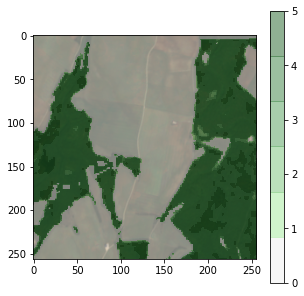

In [22]:
id = 40

plt.figure(figsize=(5,5))
plt.imshow(2.5*x_train_raw[id])
plt.imshow(y_train_raw[id], vmin=0, vmax=5, alpha=.5, cmap=tree_cmap)
plt.colorbar()

In [23]:
x_train_raw.shape

(140, 256, 256, 3)

In [24]:
y_train_raw.shape

(140, 256, 256, 1)

In [25]:
np.unique(y_train_raw[0])

array([0, 1, 2, 3, 4, 5], dtype=uint8)